## **Section 1: Data Pre-Processing**

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes.csv')

# Stores columns where 0 is not a valid value and should be treated as missing
invalid_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Replaces the columns with 0 with missing values
df[invalid_cols] = df[invalid_cols].replace(0, np.nan)

#Replace the missing values with the median
df[invalid_cols] = df[invalid_cols].fillna(df[invalid_cols].median())

# Define features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Scale the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

#Display the first 5 rows of the dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## **Section 2: Visualizations**

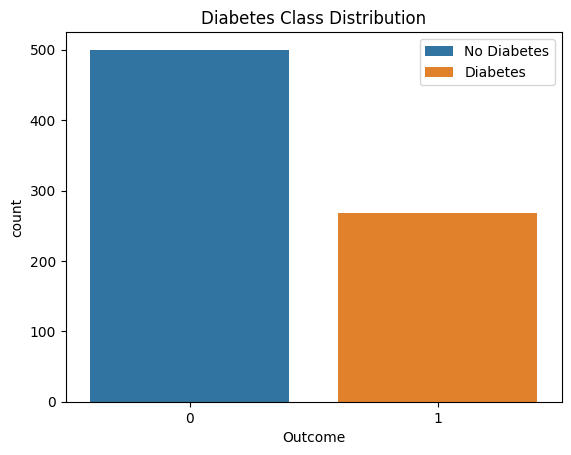

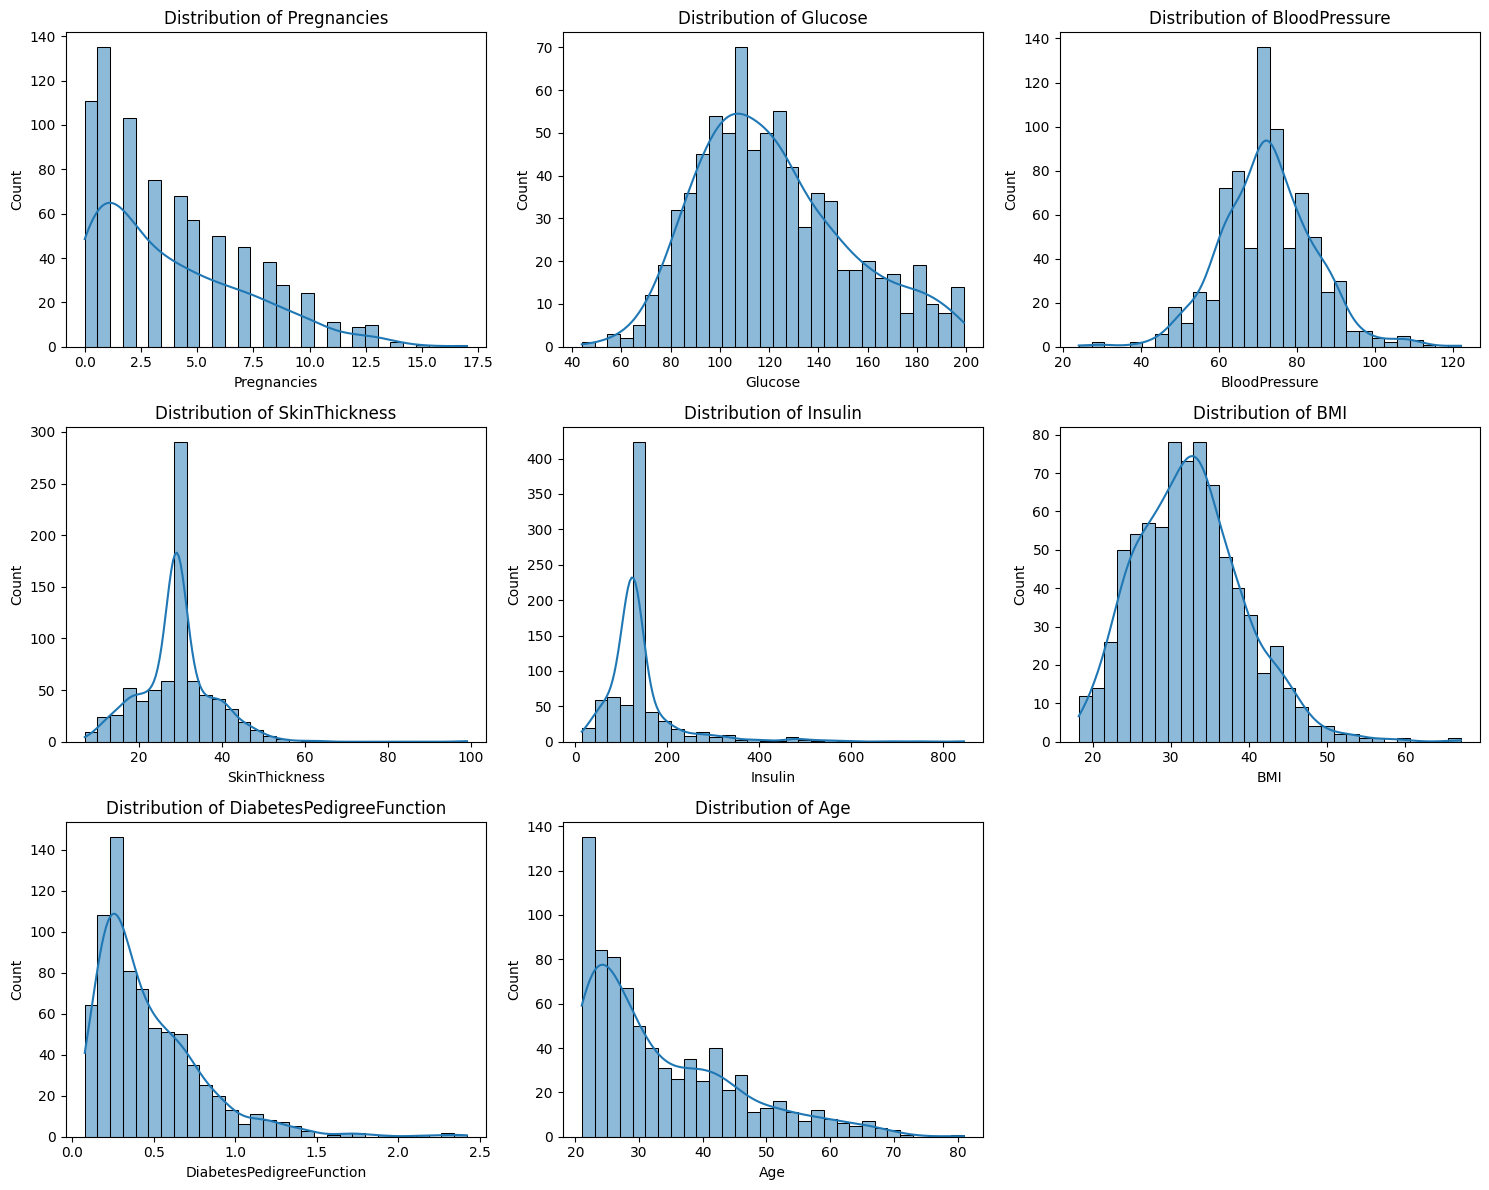

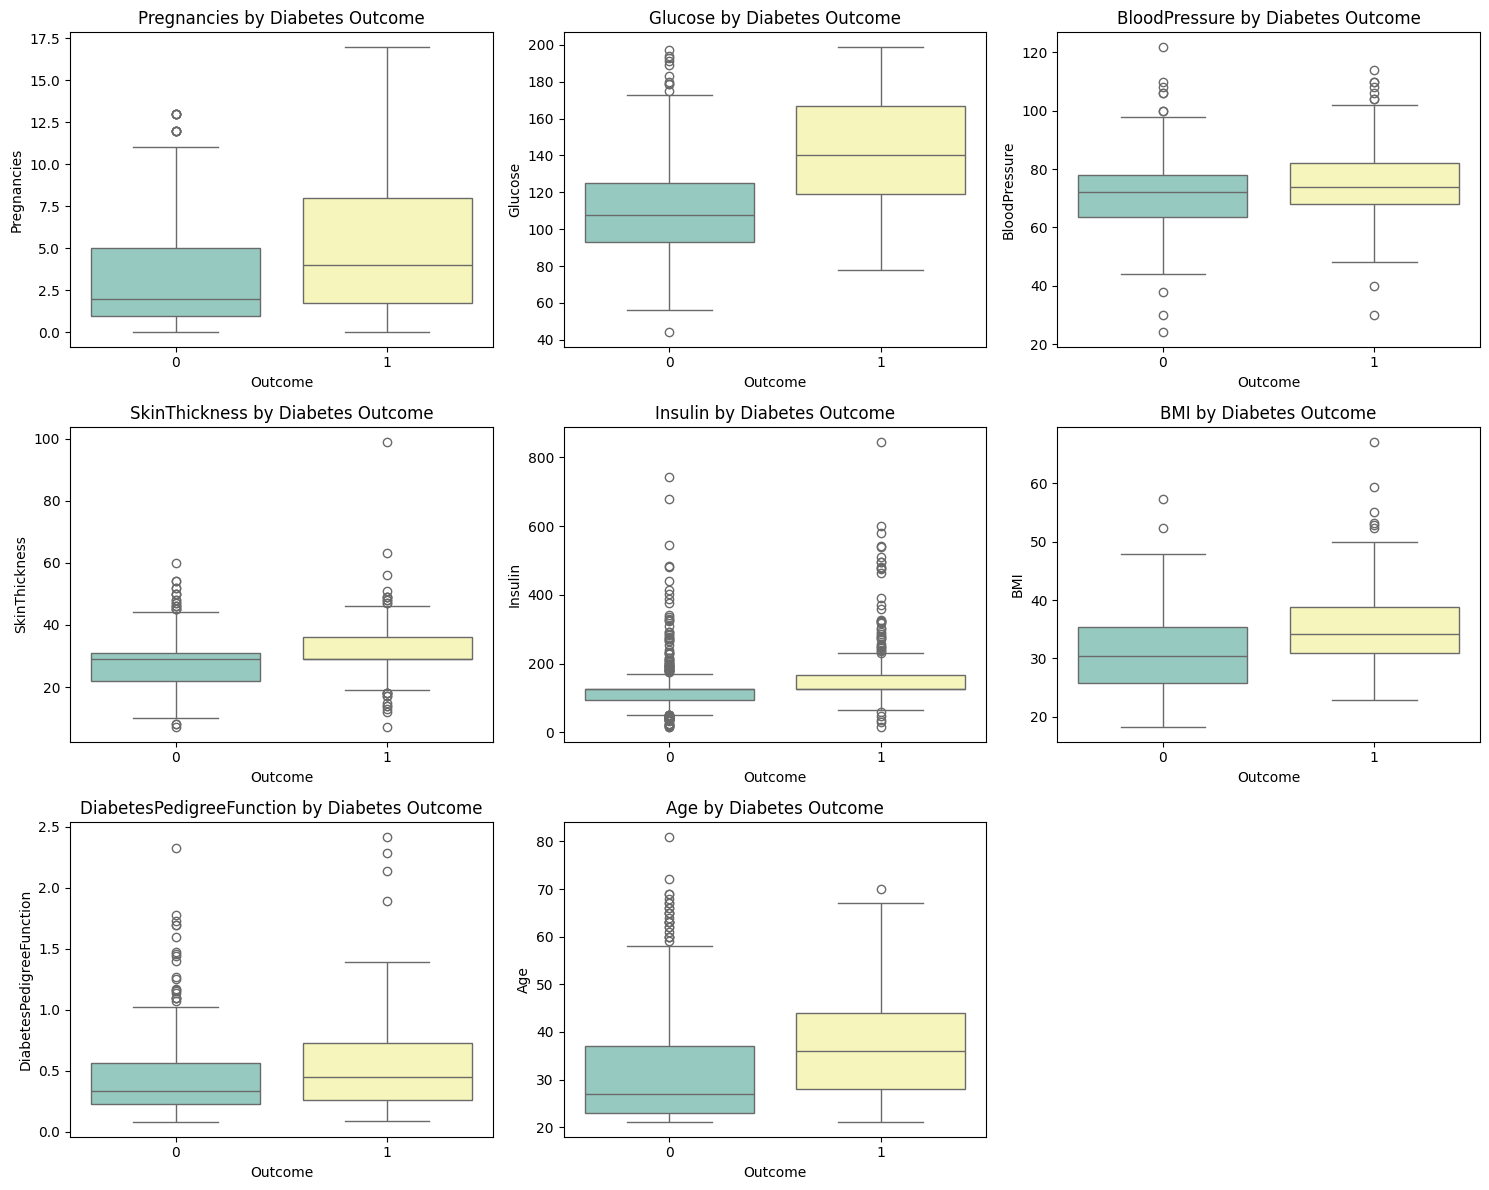

In [ ]:
#Display the breakdown between those with diabetes and those without it
sns.countplot(x='Outcome', data=df, hue='Outcome')
plt.title('Diabetes Class Distribution')
plt.legend(['No Diabetes', 'Diabetes'])
plt.show()

# Plot distributions of numerical features
num_cols = df.columns[:-1]  # Exclude 'Outcome'
plt.figure(figsize=(15, 12))
#iterate through the columns to plot the different graphs
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

#Use boxplots to compare each feature by diabetes outcome (0 or 1)
plt.figure(figsize=(15, 12))  # Set figure size
for i, col in enumerate(num_cols, 1):  # Loop through all features
    plt.subplot(3, 3, i)  # Subplot for each feature
    sns.boxplot(data=df, x="Outcome", y=col, hue="Outcome", palette="Set3", legend=False)  # Create boxplot grouped by outcome
    plt.title(f"{col} by Diabetes Outcome")  # Set title
plt.tight_layout()  # Auto-adjust layout
plt.show()  # Display all plots

**Summary of Initial Visualizations**

From the distribution graphs and boxplots, several conclusions can be made.


1. Pregnancies: The distribution is clearly right-skewed where most women have somewhere between 0-4 pregnancies. The boxplot shows that diabetic patients typically have more pregnancies since there is a higher median, which suggests an association between number of pregnancies and diabetes risk.
2. Glucose: There is a roughly normal distribution that is typically between 100-125 mg/dL. This is important since glucose levels above 126 ml/dL typically indicate a higher probabiltiy of diabetes and there are a considerable amount of people in this range. The boxplot also shows the most significant difference between groups as diabetic patients have significantly higher glucose levels compared to non-diabetic patients, which makes glucose a strong indicator of diabetes.
3. Blood Pressure: The distribution indicates that there is a normal distribution centered around 70-80 mmHg, which is mostly falling between the normal/healthy range. The boxplot shows that there is very little difference between the two groups meaning that it might be a worse indicator of diabetes comparatively.
4. Skin Thickness: The dataset shows that most of the population within the dataset have skin thickness of between 20-40 mm. The boxplot also shows that there is a moderate difference where diabetic patients tend to have thicker skin.
5. Insulin: The distribution shows that most people have very low values for their insulin levels, which might suggest an issue with the measurement of insulin as well as the possibility of a insulin deficiency in the population. The boxplot shows that there aren't any huge differences between the median of the two, but the distribution patterns still differ.
6. BMI: The distribution shows that there is a normal distribution around 30-35 which is considered to be obese, meaning that a large portion of the population show features of obesity. The boxplot also shows that the BMI is higher in diabetic patients compared to non-diabetic patients, which confirms the correlation between obesity and risk of diabetes.
7. Diabetes Pedigree Function: The distribution shows a right-skewed sample which shows that there are varying levels of diabetes risk based on genetic influence. The boxplot shows that the diabetes pedigree function is slightly higher in diabetic patients which proves the existence of genetic factors in diabetes risk.
8. Age: The distribution shows that the population is bimodal which suggests that there are different age groups within the dataset. The boxplot shows that diabetic patients are usually older than their counterparts, which shows the increased risk of diabetes with age.





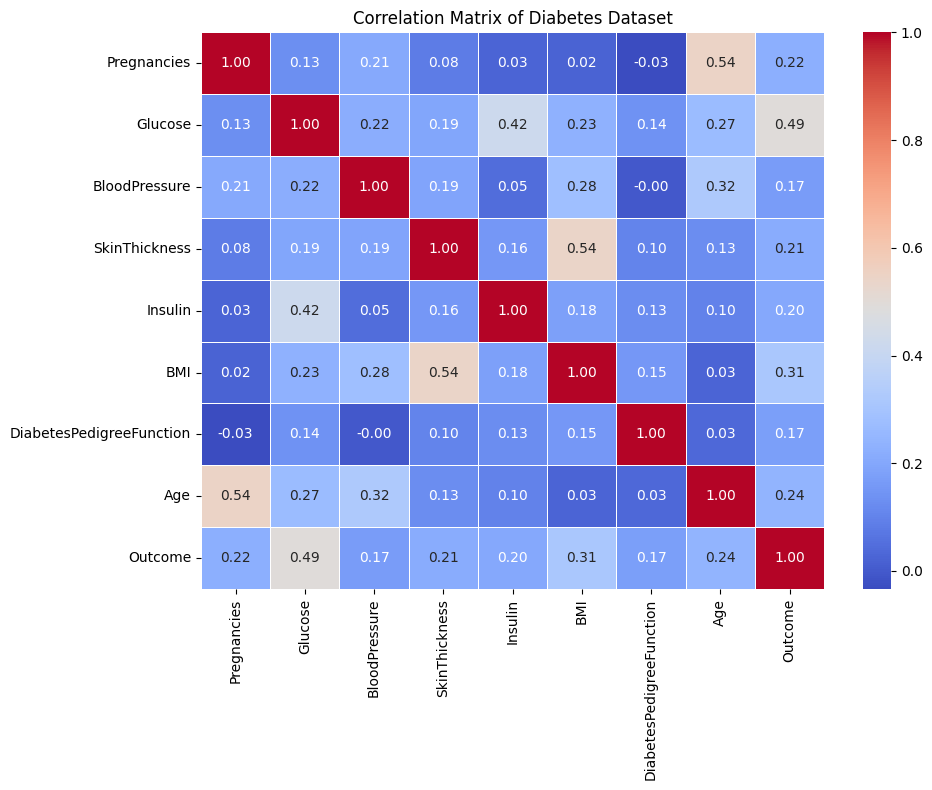

In [ ]:
#Initialize Correlation Matrix
plt.figure(figsize=(10, 8))  # Set size of the plot
correlation_matrix = df.corr()  # Compute correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)  # Draw heatmap
#Set the title
plt.title("Correlation Matrix of Diabetes Dataset")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Display the plot

**Summary of Correlation Matrix**

The correlation matrix shows that glucose clearly has the highest correlation to the outcome(0.49), which proves its importnce as a predictor of diabetes. Another important factor that we can see from the correlation matrix is BMI which has a correlation to the outcome of 0.31. The matrix also shows that Age and Pregnancies, with correlations of 0.24 and 0.22 alike round out the key indicators of diabetes. We can also see that features like Blood Pressure(with a correlation to outcome of 0.17) and Diabetes Pedigree Function(0.17), surprisingly show little correlation with diabetes outcome. This matrix informs us that the key features that can be used to predict diabetes are Glucode and BMI.

## **Section 3: Supervised Learning and Feature Importance**

Model: Logistic Regression
Accuracy: 0.7532
Classification Report:
              precision    recall  f1-score     support
0              0.796117  0.828283  0.811881   99.000000
1              0.666667  0.618182  0.641509   55.000000
accuracy       0.753247  0.753247  0.753247    0.753247
macro avg      0.731392  0.723232  0.726695  154.000000
weighted avg   0.749884  0.753247  0.751034  154.000000
Confusion Matrix: 
[[82 17]
 [21 34]]
Model: Random Forest
Accuracy: 0.7662
Classification Report:
              precision    recall  f1-score     support
0              0.811881  0.828283  0.820000   99.000000
1              0.679245  0.654545  0.666667   55.000000
accuracy       0.766234  0.766234  0.766234    0.766234
macro avg      0.745563  0.741414  0.743333  154.000000
weighted avg   0.764511  0.766234  0.765238  154.000000
Confusion Matrix: 
[[82 17]
 [19 36]]
Model: K-Nearest Neighbors
Accuracy: 0.7338
Classification Report:
              precision    recall  f1-score     support
0

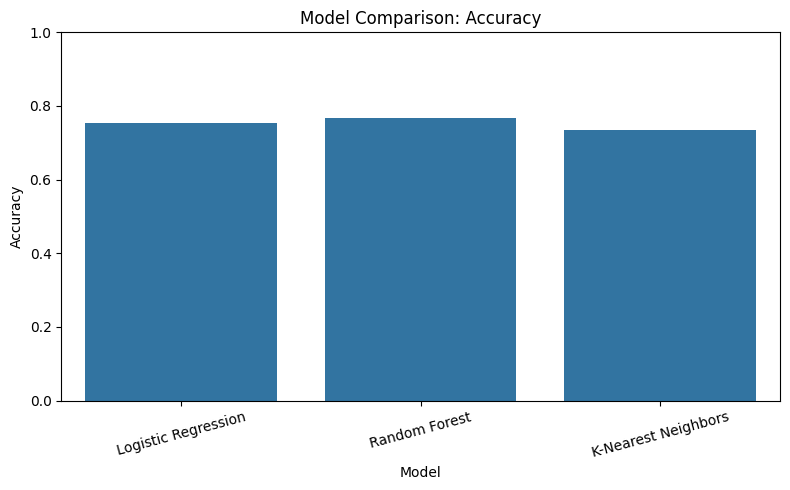

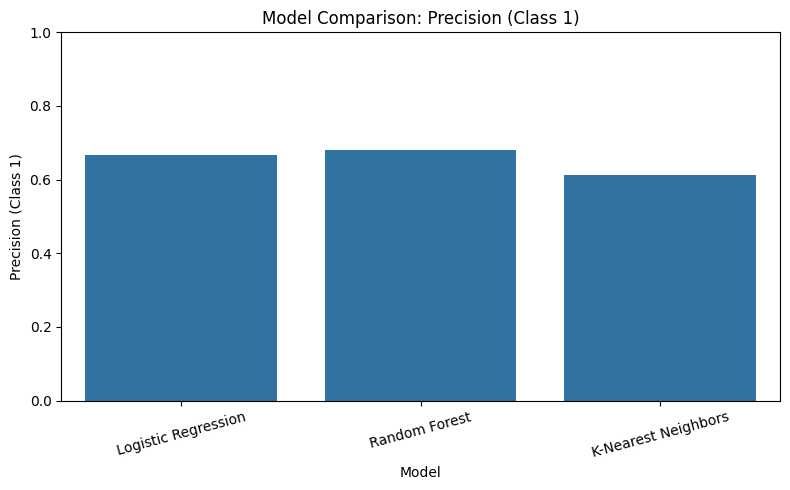

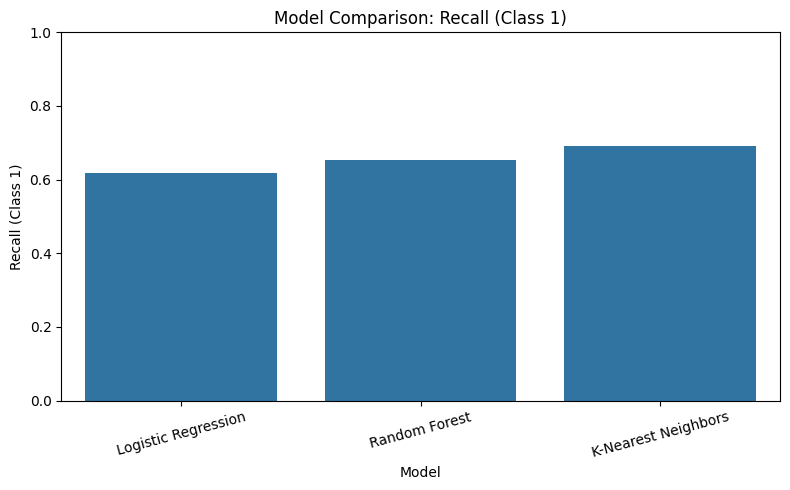

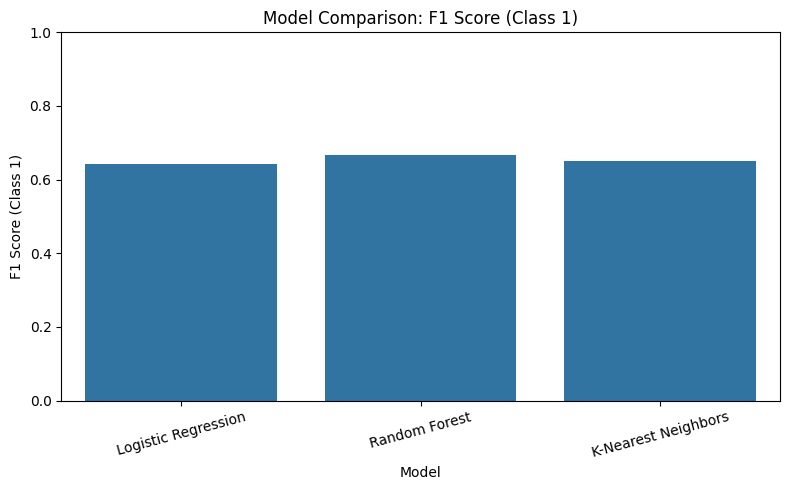

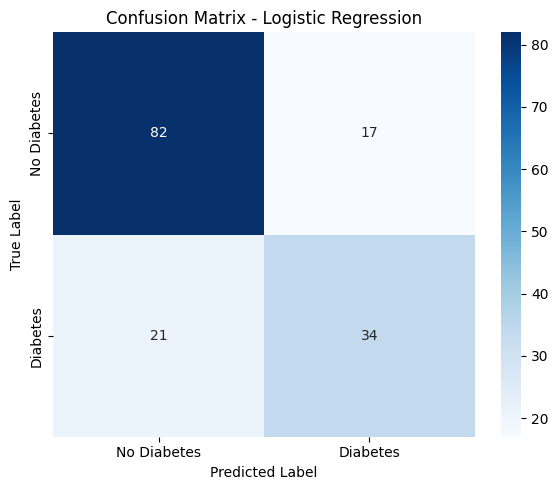

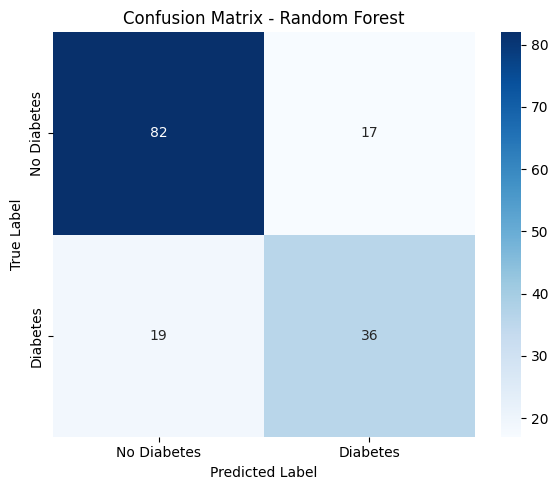

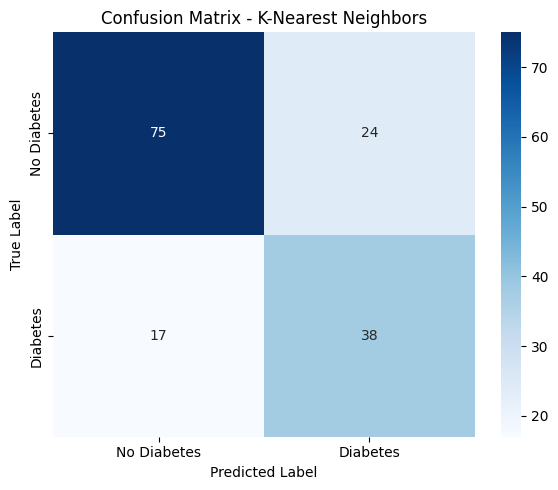

In [ ]:
class MLModel:
  def __init__(self, X_train, X_test, y_train, y_test):
    '''
    Constructor for the MLModel class that initializes a dataframe and the name of the target column.
    Automatically seperates the features as X and the target as y.
    '''
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.results = {}  #Stores accuracy, classification report, and confusion matrix for each model

  def train_and_evaluate(self):
    '''
    Train logistic regression, random forest, and KNN models
    Store their accuracy, classification report, and confusion matrix
    '''
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier()
    }

    for name, model in models.items():
      # Train the model
      model.fit(self.X_train, self.y_train)
      # Make predictions on test data
      predictions = model.predict(self.X_test)
      # Evaluate performance
      accuracy = accuracy_score(self.y_test, predictions)
      report = classification_report(self.y_test, predictions, output_dict = True)
      cm = confusion_matrix(self.y_test, predictions)

      # Store results in dictionary
      self.results[name] = {
          "Accuracy": accuracy,
          "Classification Report": report,
          "Confusion Matrix": cm
      }

  def display_results(self):
      '''
      Prints out the accuracy and evaluation metrics for all of the trained models.
      '''
      for model_name, metrics in self.results.items():
        print(f"Model: {model_name}")
        print(f"Accuracy: {metrics['Accuracy']:.4f}")
        print("Classification Report:")
        print(pd.DataFrame(metrics["Classification Report"]).transpose())
        print("Confusion Matrix: ")
        print(metrics["Confusion Matrix"])

  def plot_model_comparison(self):
      """
      Generate bar plots comparing accuracy, precision, recall, and F1 score across all models.
      """
      model_names = list(self.results.keys())
      # Extract evaluation metrics for class 1 (diabetic cases)
      accuracies = [self.results[m]['Accuracy'] for m in model_names]
      precisions = [self.results[m]['Classification Report']['1']['precision'] for m in model_names]
      recalls = [self.results[m]['Classification Report']['1']['recall'] for m in model_names]
      f1_scores = [self.results[m]['Classification Report']['1']['f1-score'] for m in model_names]

      # Organize metrics into a dictionary for plotting
      metrics = {
          "Accuracy": accuracies,
          "Precision (Class 1)": precisions,
          "Recall (Class 1)": recalls,
          "F1 Score (Class 1)": f1_scores
      }

      # Create bar plot for each metric
      for metric_name, values in metrics.items():
          plt.figure(figsize=(8, 5))
          sns.barplot(x=model_names, y=values)
          plt.ylim(0, 1)
          plt.title(f"Model Comparison: {metric_name}")
          plt.ylabel(metric_name)
          plt.xlabel("Model")
          plt.xticks(rotation=15)
          plt.tight_layout()
          plt.show()

  def plot_confusion_matrices(self):
      '''
      Plot confusion matrices for all models.
      '''
      for model_name, metrics in self.results.items():
          cm = metrics['Confusion Matrix']
          plt.figure(figsize=(6, 5))
          sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                      xticklabels=["No Diabetes", "Diabetes"],
                      yticklabels=["No Diabetes", "Diabetes"])
          plt.title(f"Confusion Matrix - {model_name}")
          plt.xlabel("Predicted Label")
          plt.ylabel("True Label")
          plt.tight_layout()
          plt.show()

evaluator = MLModel(X_train, X_test, y_train, y_test)
evaluator.train_and_evaluate()
evaluator.display_results()
evaluator.plot_model_comparison()
evaluator.plot_confusion_matrices()

**Summary of ML Model Evaluation**

From these results, we can see that the Random Forest model performed the best with a 76.62% accuracy, with Logistic Regression(75.32%) coming in second and KNN(73.38%)coming in third. Additionally, the Random Forest and Logistic Regression models have the highest precision(0.667) for diabetic cases which means that when someone actually has diabetes, they're equally likely to predict it. The Random Forest and KNN models also have an equally high recall(0.691) for diabetic cases which means that they identify the highest amount of the actual diabetic cases, compared to Logistic Regression which had a recall of 0.618. The Random Forest model also returned the highest F1 score(0.679) meaning it had the best balance between precision and recall between the 3 models. Overall, Random Forest proved to be the best model, but even in the best case it missed about 31% of diabetic cases. While these models can provide some tools, they should be further analyzed with clinical trials in order to ensure a more accurate representation.

ExactExplainer explainer: 155it [00:32,  4.46it/s]


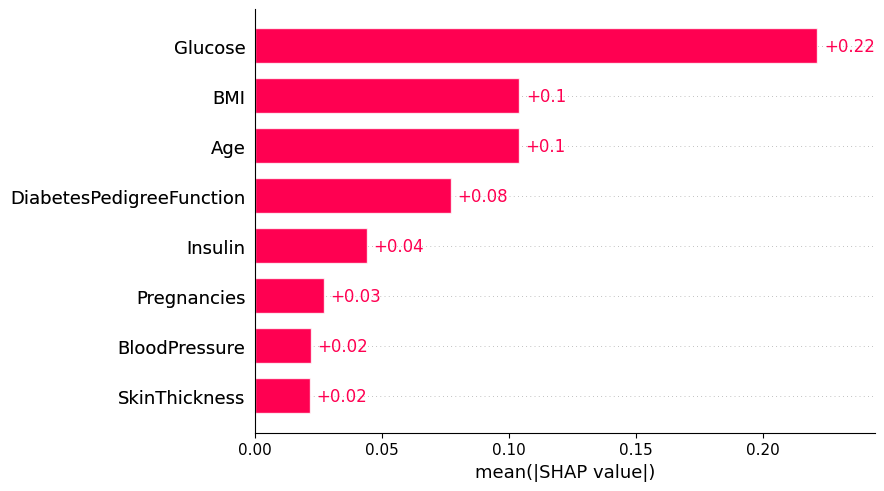

In [ ]:
#Feature Importance Visualization


# Train the model and assign to rf_model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Turn X_test into a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Use SHAP's Explainer
explainer = shap.Explainer(rf_model.predict, X_test_df)

# Get SHAP values
shap_values = explainer(X_test_df)

# Plot feature importance
shap.plots.bar(shap_values)

**Summary of Feature Analysis**

As seen by the SHAP summary, it can be concluded that Glucose is the most important feature with the strongest impact on model prediction. This result is in line with medical predictions and knowledge as well, since high blood glucose is usually a pretty key characteristic of diabetes. Some other factors that are important in predicting a diabetes diagnosis include AGE and BMI, which again, are known risk factors for diabetes. Other features, like Diabetes Pedigree(family history) play a smaller role in prediction and insulin, blood pressure, pregnancies, and skin thickness are all much smaller contributing factors. Overall, the model relies mostly on Glucose, BMI, and Age when predicting diabetes.

**Data Set**

https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data

**References**


https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/

https://www.nhs.uk/conditions/diabetes/

https://www.w3schools.com/python/python_ml_confusion_matrix.asp

https://www.w3schools.com/datascience/ds_stat_correlation_matrix.asp

https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability

